In [2]:
import sys
sys.path.insert(0, "..")

from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [5]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1979-01-01,267.544885,263.215940,265.614798,269.246152,270.986939,0.645568,0.411641,0.493207,0.786807,0.968296,...,5.416634e-02,8.587498e-02,2.584887e-01,3.476734e-01,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,260.314148,255.619375,258.972292,262.103567,263.020220,0.820650,0.397585,0.629716,1.034454,1.198080,...,3.145957e-02,5.862977e-02,1.163452e-01,1.879131e-01,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,261.005400,256.276955,258.949227,263.207223,264.551532,0.556613,0.284256,0.381780,0.731949,1.006851,...,8.019026e-02,1.585278e-01,4.063342e-01,6.399767e-01,0.100000,0.0,0.0,0.00,1.00,NaN
1979-01-04,261.831189,257.565472,260.119045,263.598178,264.915965,0.130478,0.062119,0.095452,0.158678,0.238096,...,1.396269e-01,3.109749e-01,5.911962e-01,1.245654e+00,0.466667,0.0,0.0,1.00,1.00,NaN
1979-01-05,263.617705,259.486833,261.757586,265.343948,266.938879,0.112703,-0.024442,0.041305,0.171891,0.209796,...,8.875974e-04,1.595687e-03,3.276934e-03,5.418987e-03,0.466667,0.0,0.0,1.00,1.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,275.665389,272.532531,274.011570,277.077125,279.046970,0.711351,0.383844,0.520484,0.890882,1.102261,...,3.388751e-01,6.668010e-01,1.723657e+00,2.954944e+00,79.766667,0.0,0.0,165.25,265.20,14.696
2019-12-28,273.782233,270.210608,271.943333,275.284675,277.780975,0.582510,0.052560,0.312796,0.887370,1.073574,...,5.568687e-04,1.206589e-03,3.046754e-03,4.507426e-03,79.466667,0.0,0.0,165.00,264.75,12.618
2019-12-29,273.044206,269.772671,271.566083,274.625413,276.113712,0.617306,-0.045636,0.219593,1.017799,1.484095,...,0.000000e+00,2.402924e-05,1.912373e-04,4.455534e-04,79.233333,0.0,0.0,164.25,264.20,11.590
2019-12-30,273.999279,270.714283,272.726279,275.502626,276.905559,0.144457,-0.141235,-0.026259,0.292650,0.414801,...,8.705337e-05,2.793410e-04,1.082504e-03,2.161155e-03,79.100000,0.0,0.0,164.25,264.20,10.939


In [6]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-0.7, 0, 6)
epsilon_range=np.logspace(-3, -2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

In [ ]:
#previous c,eps were in the middle of the grid

Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits

C=0.72443596007499
eps=0.0021544346900318843


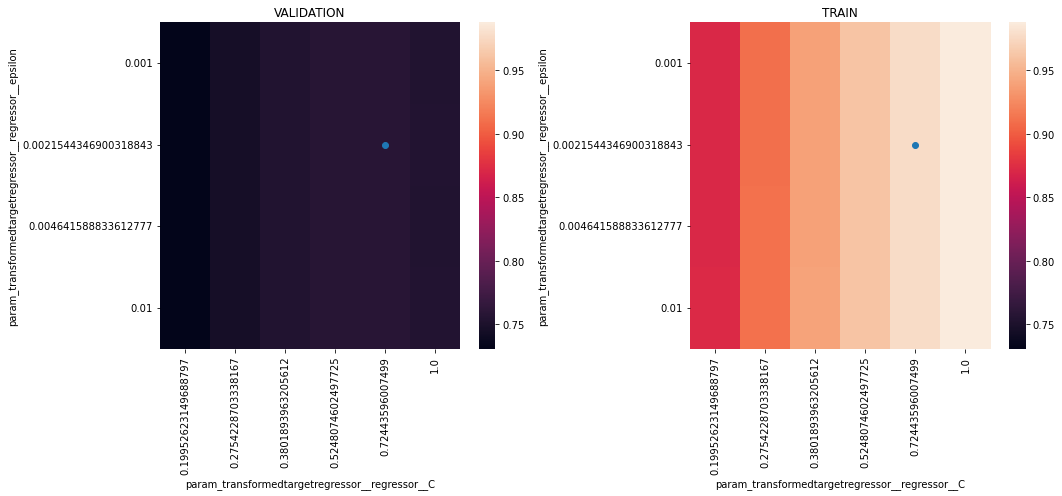

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [12]:
a=1

In [8]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

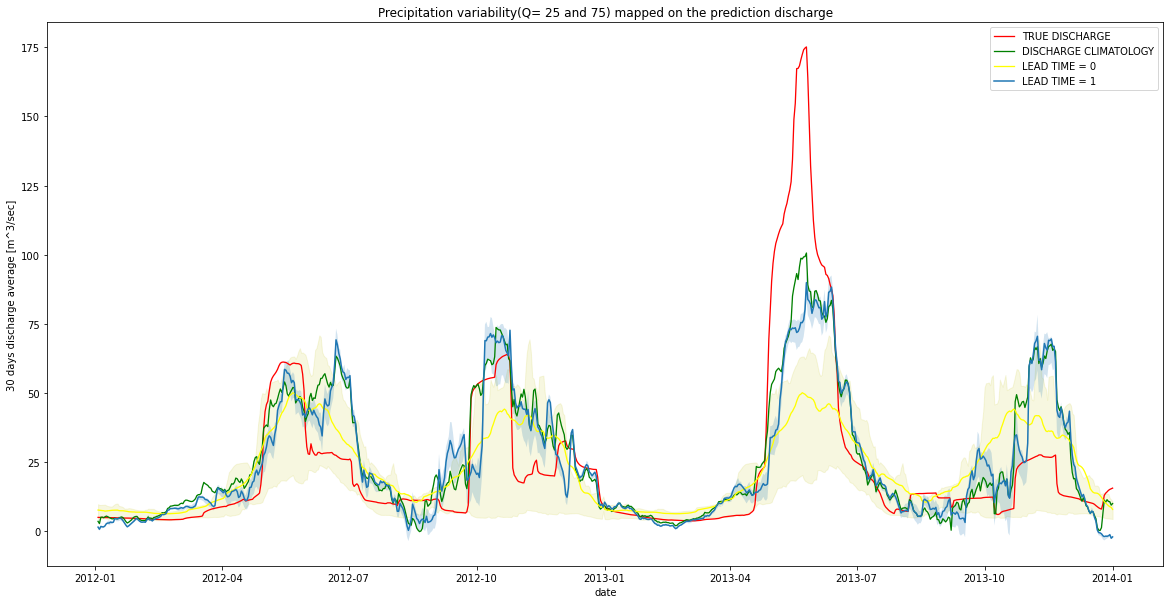

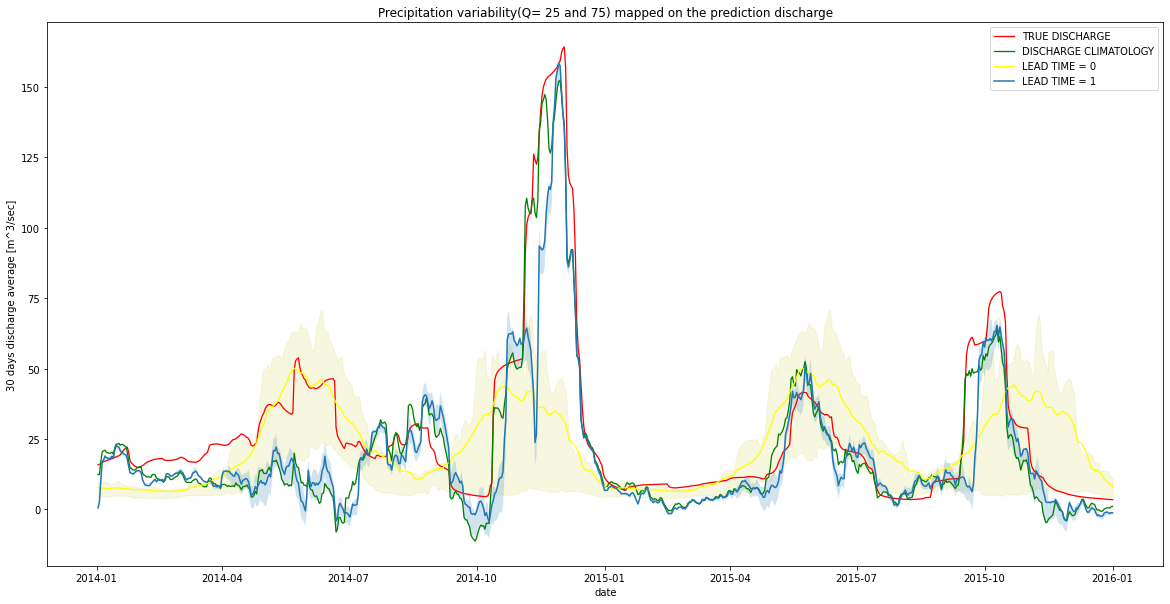

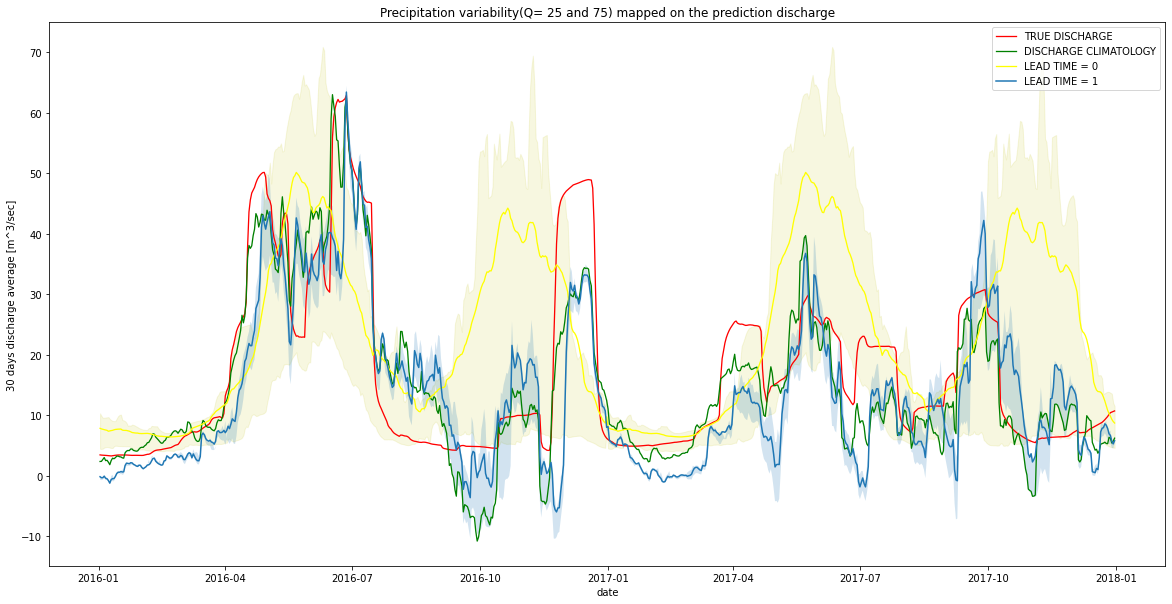

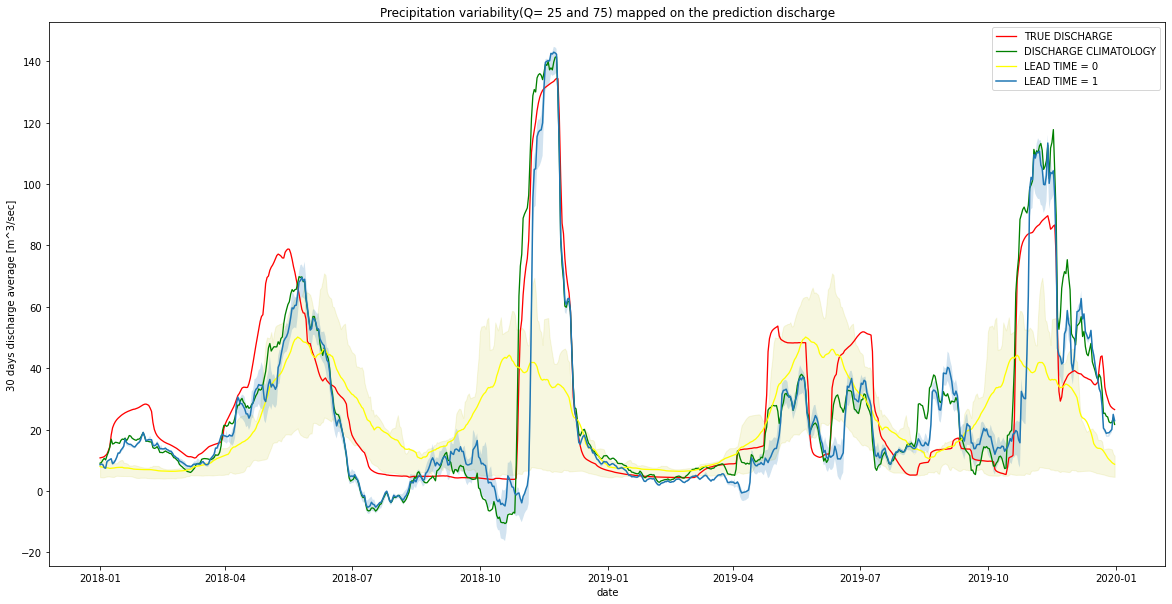

In [9]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


measured runoff             1.000000
runoff climatology          0.259166
runoff_clim_25             -0.217941
runoff_clim_75              0.138609
model output                0.779881
output 1 month lead time    0.654566
output 2 month lead time    0.455284
output 3 month lead time    0.238063
output 4 month lead time    0.212267
output 5 month lead time    0.181730
dtype: float64

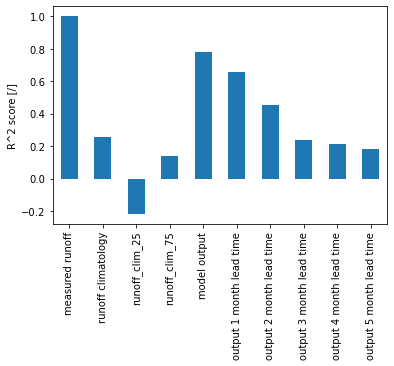

In [10]:
evaluate_prediction(predictions)

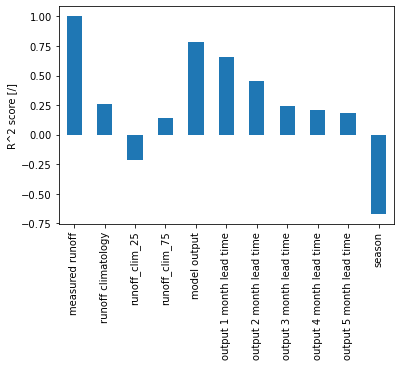

In [13]:
from cross_validation_f import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

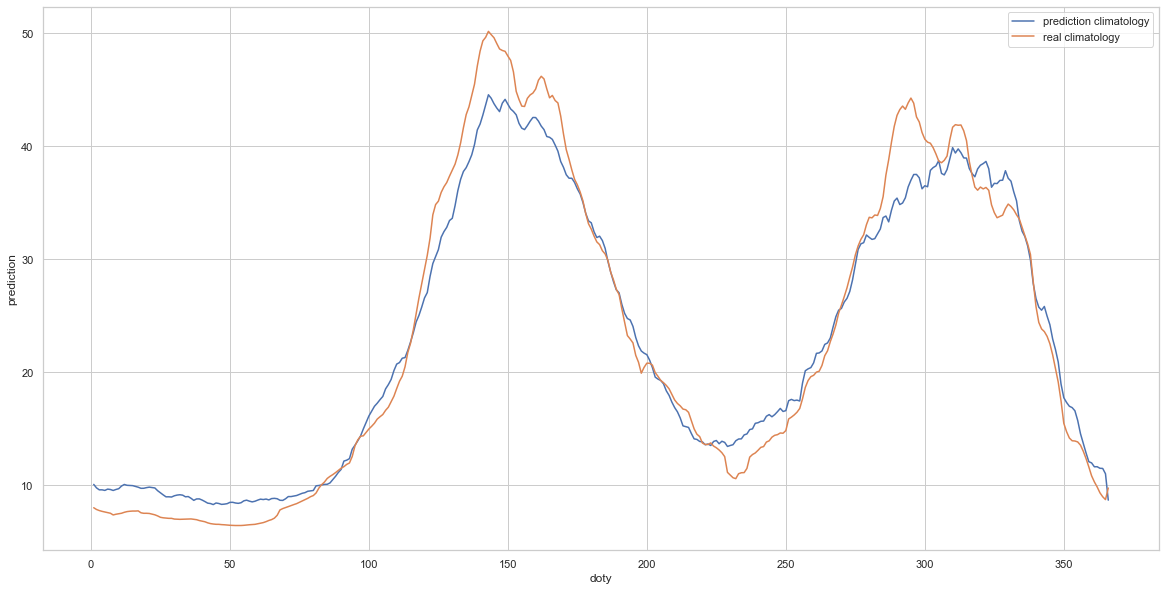

In [14]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [16]:
from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [15]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from base_f import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_CH07_0100.joblib']